# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:05<00:00, 10.9KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

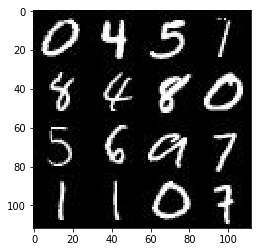

In [2]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

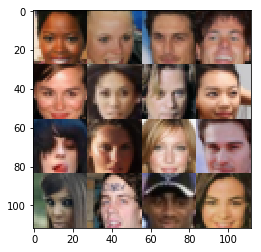

In [3]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # DONE: Implement Function
    input_real_ph = tf.placeholder(
        tf.float32,
        [None, image_width, image_height, image_channels],
        name='input_real')
    
    input_z_ph = tf.placeholder(
        tf.float32,
        [None, z_dim],
        name='input_z')
    
    learning_rate_ph = tf.placeholder(
        tf.float32,
        [],
        name='learning_rate')

    return input_real_ph, input_z_ph, learning_rate_ph


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [51]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # DONE: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        
        # Convolution
        input_image = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        input_image = tf.maximum(alpha * input_image, input_image)
        # 14x14x32 now
        
        # Convolution
        conv1 = tf.layers.conv2d(input_image, 64, 5, strides=2, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=True)
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 7x7x64 now
        
        # Flatten
        flat = tf.reshape(conv1, (-1, 7*7*64))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [99]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # DONE: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):

        # Fully Conn
        dense = tf.layers.dense(z, 7*7*64)
        
        # Reshape
        reshape = tf.reshape(dense, (-1, 7, 7, 64))
        # 7x7x64 now
        
        # Convolution
        conv1 = tf.layers.conv2d_transpose(
            reshape,
            32,
            5,
            strides=2,
            padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x32 now
        
        # Convolution
        logits = tf.layers.conv2d_transpose(
            conv1,
            out_channel_dim,
            5, strides=2,
            padding='same')
        # 28x28x3 now
        
        output = tf.tanh(logits)
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [100]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # DONE: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [101]:

def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [102]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train.

In [103]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # DONE: Build Model
    _ , img_w, img_h, img_d = data_shape
    real_input, z_input, lr = model_inputs(img_w, img_h, img_d, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, img_d)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    losses = []
    print_every = 10
    show_every = 100
    
    figsize=(5,5)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2 # converting -.5 .5 to -1 1
                steps += 1
                z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: z, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, z_input, img_d, data_image_mode)
                    
    return losses
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.

Epoch 1/2... Discriminator Loss: 0.7555... Generator Loss: 0.9417
Epoch 1/2... Discriminator Loss: 0.4711... Generator Loss: 1.5705
Epoch 1/2... Discriminator Loss: 0.2720... Generator Loss: 2.1497
Epoch 1/2... Discriminator Loss: 0.4410... Generator Loss: 1.9036
Epoch 1/2... Discriminator Loss: 0.6489... Generator Loss: 1.0263
Epoch 1/2... Discriminator Loss: 0.6233... Generator Loss: 1.6320
Epoch 1/2... Discriminator Loss: 0.4893... Generator Loss: 1.5451
Epoch 1/2... Discriminator Loss: 0.5356... Generator Loss: 1.4314
Epoch 1/2... Discriminator Loss: 0.5720... Generator Loss: 1.3478
Epoch 1/2... Discriminator Loss: 0.6091... Generator Loss: 1.1557


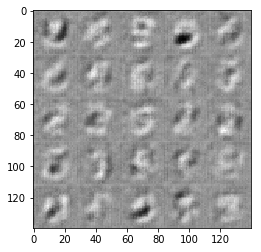

Epoch 1/2... Discriminator Loss: 0.9558... Generator Loss: 2.5208
Epoch 1/2... Discriminator Loss: 0.7924... Generator Loss: 1.0669
Epoch 1/2... Discriminator Loss: 0.9865... Generator Loss: 0.7354
Epoch 1/2... Discriminator Loss: 0.8400... Generator Loss: 0.8159
Epoch 1/2... Discriminator Loss: 1.4116... Generator Loss: 2.2481
Epoch 1/2... Discriminator Loss: 0.8484... Generator Loss: 1.2001
Epoch 1/2... Discriminator Loss: 1.0145... Generator Loss: 0.6370
Epoch 1/2... Discriminator Loss: 0.9370... Generator Loss: 0.6811
Epoch 1/2... Discriminator Loss: 0.9063... Generator Loss: 0.8029
Epoch 1/2... Discriminator Loss: 1.0234... Generator Loss: 0.6564


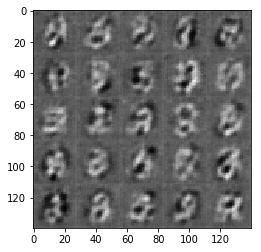

Epoch 1/2... Discriminator Loss: 0.9006... Generator Loss: 0.7285
Epoch 1/2... Discriminator Loss: 0.8898... Generator Loss: 1.4479
Epoch 1/2... Discriminator Loss: 0.7384... Generator Loss: 1.4026
Epoch 1/2... Discriminator Loss: 0.9860... Generator Loss: 0.7583
Epoch 1/2... Discriminator Loss: 0.9507... Generator Loss: 0.8263
Epoch 1/2... Discriminator Loss: 0.8895... Generator Loss: 0.8311
Epoch 1/2... Discriminator Loss: 0.8855... Generator Loss: 1.3395
Epoch 1/2... Discriminator Loss: 0.9090... Generator Loss: 1.0768
Epoch 1/2... Discriminator Loss: 1.1377... Generator Loss: 0.5217
Epoch 1/2... Discriminator Loss: 0.8662... Generator Loss: 0.9726


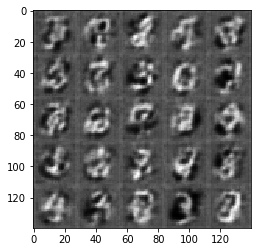

Epoch 1/2... Discriminator Loss: 0.8118... Generator Loss: 1.1834
Epoch 1/2... Discriminator Loss: 0.9005... Generator Loss: 0.8448
Epoch 1/2... Discriminator Loss: 0.8713... Generator Loss: 0.9760
Epoch 1/2... Discriminator Loss: 0.9911... Generator Loss: 1.8204
Epoch 1/2... Discriminator Loss: 0.9448... Generator Loss: 1.1037
Epoch 1/2... Discriminator Loss: 0.9017... Generator Loss: 0.7679
Epoch 1/2... Discriminator Loss: 0.9010... Generator Loss: 0.8560
Epoch 1/2... Discriminator Loss: 1.3317... Generator Loss: 2.4599
Epoch 1/2... Discriminator Loss: 0.9389... Generator Loss: 0.8502
Epoch 1/2... Discriminator Loss: 0.7807... Generator Loss: 1.2455


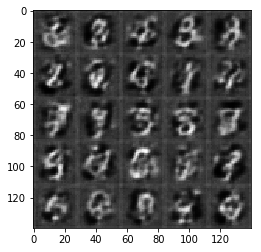

Epoch 1/2... Discriminator Loss: 0.7289... Generator Loss: 1.1716
Epoch 1/2... Discriminator Loss: 0.7327... Generator Loss: 1.0745
Epoch 1/2... Discriminator Loss: 0.8221... Generator Loss: 1.6471
Epoch 1/2... Discriminator Loss: 0.7815... Generator Loss: 0.8328
Epoch 1/2... Discriminator Loss: 1.0026... Generator Loss: 0.5769
Epoch 1/2... Discriminator Loss: 0.7455... Generator Loss: 1.4282
Epoch 1/2... Discriminator Loss: 0.6731... Generator Loss: 1.1721
Epoch 1/2... Discriminator Loss: 0.8144... Generator Loss: 0.8017
Epoch 1/2... Discriminator Loss: 0.7585... Generator Loss: 0.8885
Epoch 1/2... Discriminator Loss: 0.7765... Generator Loss: 1.8740


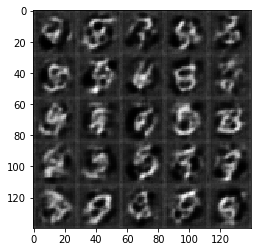

Epoch 1/2... Discriminator Loss: 0.7041... Generator Loss: 1.5999
Epoch 1/2... Discriminator Loss: 0.8418... Generator Loss: 0.8103
Epoch 1/2... Discriminator Loss: 0.6914... Generator Loss: 1.9486
Epoch 1/2... Discriminator Loss: 0.6747... Generator Loss: 1.4726
Epoch 1/2... Discriminator Loss: 1.0000... Generator Loss: 0.5969
Epoch 1/2... Discriminator Loss: 0.6382... Generator Loss: 1.3443
Epoch 1/2... Discriminator Loss: 0.6116... Generator Loss: 1.1974
Epoch 1/2... Discriminator Loss: 0.7276... Generator Loss: 2.0726
Epoch 1/2... Discriminator Loss: 0.6642... Generator Loss: 1.4770
Epoch 1/2... Discriminator Loss: 0.6173... Generator Loss: 1.6160


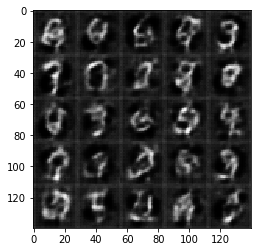

Epoch 1/2... Discriminator Loss: 0.5521... Generator Loss: 1.4471
Epoch 1/2... Discriminator Loss: 0.6088... Generator Loss: 1.6221
Epoch 1/2... Discriminator Loss: 0.7339... Generator Loss: 0.9466
Epoch 1/2... Discriminator Loss: 0.7837... Generator Loss: 0.8242
Epoch 1/2... Discriminator Loss: 0.6938... Generator Loss: 2.0145
Epoch 1/2... Discriminator Loss: 0.5858... Generator Loss: 1.2219
Epoch 1/2... Discriminator Loss: 0.6005... Generator Loss: 1.7475
Epoch 1/2... Discriminator Loss: 0.6032... Generator Loss: 1.3870
Epoch 1/2... Discriminator Loss: 0.6188... Generator Loss: 1.1329
Epoch 1/2... Discriminator Loss: 0.6518... Generator Loss: 1.0690


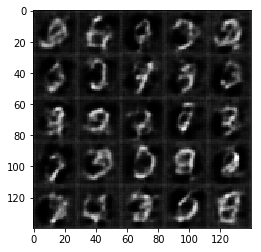

Epoch 1/2... Discriminator Loss: 0.8120... Generator Loss: 0.7606
Epoch 1/2... Discriminator Loss: 0.5730... Generator Loss: 1.6746
Epoch 1/2... Discriminator Loss: 0.6974... Generator Loss: 0.9657
Epoch 1/2... Discriminator Loss: 0.5425... Generator Loss: 1.5593
Epoch 1/2... Discriminator Loss: 0.5722... Generator Loss: 1.5350
Epoch 1/2... Discriminator Loss: 0.7218... Generator Loss: 1.7616
Epoch 1/2... Discriminator Loss: 0.5366... Generator Loss: 1.7218
Epoch 1/2... Discriminator Loss: 0.7539... Generator Loss: 0.9624
Epoch 1/2... Discriminator Loss: 0.6105... Generator Loss: 1.2400
Epoch 1/2... Discriminator Loss: 0.7102... Generator Loss: 1.4695


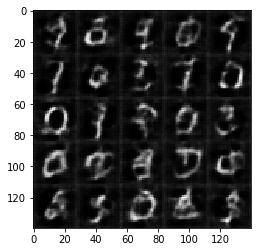

Epoch 1/2... Discriminator Loss: 0.5343... Generator Loss: 1.9646
Epoch 1/2... Discriminator Loss: 0.7102... Generator Loss: 0.9454
Epoch 1/2... Discriminator Loss: 0.6791... Generator Loss: 1.1609
Epoch 1/2... Discriminator Loss: 0.5626... Generator Loss: 1.4634
Epoch 1/2... Discriminator Loss: 0.9126... Generator Loss: 2.2935
Epoch 1/2... Discriminator Loss: 0.8247... Generator Loss: 1.0475
Epoch 1/2... Discriminator Loss: 0.5106... Generator Loss: 1.9304
Epoch 1/2... Discriminator Loss: 0.5577... Generator Loss: 1.9839
Epoch 1/2... Discriminator Loss: 0.5489... Generator Loss: 1.8210
Epoch 1/2... Discriminator Loss: 0.9205... Generator Loss: 3.1922


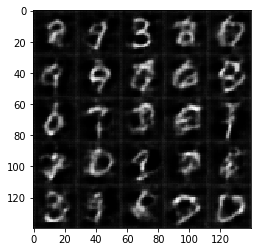

Epoch 1/2... Discriminator Loss: 0.6107... Generator Loss: 1.7373
Epoch 1/2... Discriminator Loss: 0.6089... Generator Loss: 1.3996
Epoch 1/2... Discriminator Loss: 0.5920... Generator Loss: 1.3637
Epoch 2/2... Discriminator Loss: 0.6069... Generator Loss: 1.3054
Epoch 2/2... Discriminator Loss: 0.6327... Generator Loss: 1.2881
Epoch 2/2... Discriminator Loss: 0.8574... Generator Loss: 0.7088
Epoch 2/2... Discriminator Loss: 0.7800... Generator Loss: 2.5289
Epoch 2/2... Discriminator Loss: 0.8781... Generator Loss: 0.7797
Epoch 2/2... Discriminator Loss: 0.6114... Generator Loss: 1.4070
Epoch 2/2... Discriminator Loss: 0.5078... Generator Loss: 1.9806


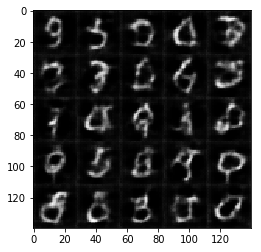

Epoch 2/2... Discriminator Loss: 0.6876... Generator Loss: 1.0254
Epoch 2/2... Discriminator Loss: 0.7601... Generator Loss: 0.8614
Epoch 2/2... Discriminator Loss: 0.7082... Generator Loss: 2.1619
Epoch 2/2... Discriminator Loss: 0.6891... Generator Loss: 1.6614
Epoch 2/2... Discriminator Loss: 0.4945... Generator Loss: 1.9821
Epoch 2/2... Discriminator Loss: 0.7831... Generator Loss: 1.2639
Epoch 2/2... Discriminator Loss: 0.6000... Generator Loss: 1.9046
Epoch 2/2... Discriminator Loss: 0.7139... Generator Loss: 1.9746
Epoch 2/2... Discriminator Loss: 0.7308... Generator Loss: 0.9905
Epoch 2/2... Discriminator Loss: 0.7074... Generator Loss: 1.5016


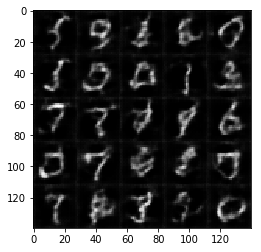

Epoch 2/2... Discriminator Loss: 0.6013... Generator Loss: 1.2692
Epoch 2/2... Discriminator Loss: 0.5631... Generator Loss: 1.7798
Epoch 2/2... Discriminator Loss: 0.6327... Generator Loss: 1.7532
Epoch 2/2... Discriminator Loss: 0.8219... Generator Loss: 0.8147
Epoch 2/2... Discriminator Loss: 0.5834... Generator Loss: 1.7280
Epoch 2/2... Discriminator Loss: 0.7809... Generator Loss: 2.2736
Epoch 2/2... Discriminator Loss: 0.5530... Generator Loss: 1.6277
Epoch 2/2... Discriminator Loss: 0.5631... Generator Loss: 1.1814
Epoch 2/2... Discriminator Loss: 0.6763... Generator Loss: 2.0469
Epoch 2/2... Discriminator Loss: 0.8966... Generator Loss: 2.2884


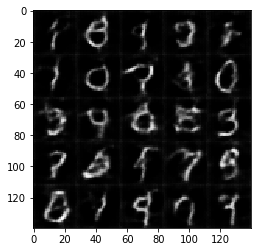

Epoch 2/2... Discriminator Loss: 1.0248... Generator Loss: 0.8970
Epoch 2/2... Discriminator Loss: 0.7301... Generator Loss: 1.5076
Epoch 2/2... Discriminator Loss: 0.9659... Generator Loss: 0.7809
Epoch 2/2... Discriminator Loss: 0.6724... Generator Loss: 1.0945
Epoch 2/2... Discriminator Loss: 0.6944... Generator Loss: 1.6590
Epoch 2/2... Discriminator Loss: 0.6223... Generator Loss: 1.2157
Epoch 2/2... Discriminator Loss: 0.7095... Generator Loss: 1.3711
Epoch 2/2... Discriminator Loss: 0.7738... Generator Loss: 0.9148
Epoch 2/2... Discriminator Loss: 0.6366... Generator Loss: 1.2007
Epoch 2/2... Discriminator Loss: 0.6112... Generator Loss: 1.3399


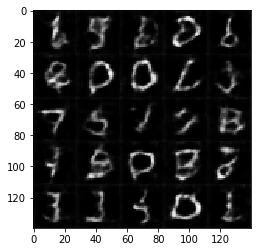

Epoch 2/2... Discriminator Loss: 0.7235... Generator Loss: 1.0713
Epoch 2/2... Discriminator Loss: 0.6979... Generator Loss: 1.9402
Epoch 2/2... Discriminator Loss: 0.6317... Generator Loss: 1.8354
Epoch 2/2... Discriminator Loss: 0.6912... Generator Loss: 1.0732
Epoch 2/2... Discriminator Loss: 0.6578... Generator Loss: 1.2932
Epoch 2/2... Discriminator Loss: 0.7688... Generator Loss: 0.8033
Epoch 2/2... Discriminator Loss: 0.6112... Generator Loss: 1.2999
Epoch 2/2... Discriminator Loss: 0.6809... Generator Loss: 1.3703
Epoch 2/2... Discriminator Loss: 0.6334... Generator Loss: 1.7361
Epoch 2/2... Discriminator Loss: 0.6115... Generator Loss: 1.3013


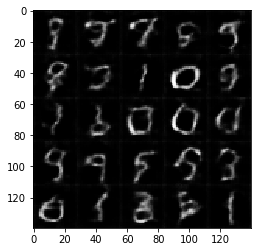

Epoch 2/2... Discriminator Loss: 0.7200... Generator Loss: 0.9197
Epoch 2/2... Discriminator Loss: 0.5605... Generator Loss: 2.3359
Epoch 2/2... Discriminator Loss: 0.7851... Generator Loss: 1.2548
Epoch 2/2... Discriminator Loss: 0.7669... Generator Loss: 1.3809
Epoch 2/2... Discriminator Loss: 0.6288... Generator Loss: 1.7414
Epoch 2/2... Discriminator Loss: 0.6186... Generator Loss: 1.4018
Epoch 2/2... Discriminator Loss: 0.6763... Generator Loss: 1.0104
Epoch 2/2... Discriminator Loss: 0.5542... Generator Loss: 1.5988
Epoch 2/2... Discriminator Loss: 0.6791... Generator Loss: 1.5778
Epoch 2/2... Discriminator Loss: 0.6800... Generator Loss: 1.1551


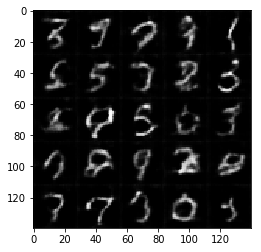

Epoch 2/2... Discriminator Loss: 1.1309... Generator Loss: 0.7317
Epoch 2/2... Discriminator Loss: 0.9084... Generator Loss: 2.0427
Epoch 2/2... Discriminator Loss: 0.7908... Generator Loss: 1.4659
Epoch 2/2... Discriminator Loss: 0.6572... Generator Loss: 1.1036
Epoch 2/2... Discriminator Loss: 0.9949... Generator Loss: 0.6748
Epoch 2/2... Discriminator Loss: 0.6126... Generator Loss: 1.3232
Epoch 2/2... Discriminator Loss: 0.6518... Generator Loss: 1.2236
Epoch 2/2... Discriminator Loss: 0.7521... Generator Loss: 1.0475
Epoch 2/2... Discriminator Loss: 0.6566... Generator Loss: 1.1450
Epoch 2/2... Discriminator Loss: 0.7630... Generator Loss: 0.9396


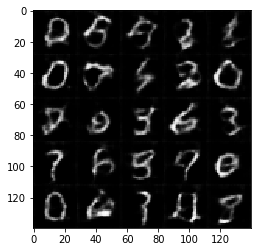

Epoch 2/2... Discriminator Loss: 0.6576... Generator Loss: 1.1754
Epoch 2/2... Discriminator Loss: 0.5604... Generator Loss: 1.4442
Epoch 2/2... Discriminator Loss: 0.6604... Generator Loss: 1.2383
Epoch 2/2... Discriminator Loss: 0.6097... Generator Loss: 1.2940
Epoch 2/2... Discriminator Loss: 0.6328... Generator Loss: 1.2610
Epoch 2/2... Discriminator Loss: 0.6789... Generator Loss: 1.1699
Epoch 2/2... Discriminator Loss: 0.5825... Generator Loss: 1.7587
Epoch 2/2... Discriminator Loss: 0.9073... Generator Loss: 2.1188
Epoch 2/2... Discriminator Loss: 0.6622... Generator Loss: 1.2692
Epoch 2/2... Discriminator Loss: 0.6101... Generator Loss: 1.2400


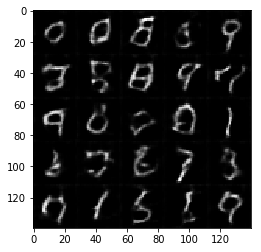

Epoch 2/2... Discriminator Loss: 0.6523... Generator Loss: 1.1633
Epoch 2/2... Discriminator Loss: 0.4824... Generator Loss: 1.5813
Epoch 2/2... Discriminator Loss: 1.2033... Generator Loss: 0.8957
Epoch 2/2... Discriminator Loss: 1.0987... Generator Loss: 1.0862
Epoch 2/2... Discriminator Loss: 1.4113... Generator Loss: 0.7044
Epoch 2/2... Discriminator Loss: 0.8865... Generator Loss: 1.1373
Epoch 2/2... Discriminator Loss: 1.1825... Generator Loss: 1.0724
Epoch 2/2... Discriminator Loss: 0.6357... Generator Loss: 2.0896
Epoch 2/2... Discriminator Loss: 0.8303... Generator Loss: 1.2031
Epoch 2/2... Discriminator Loss: 0.9297... Generator Loss: 0.9235


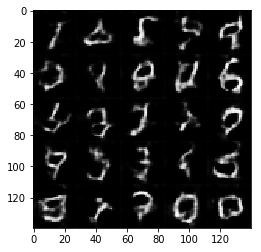

Epoch 2/2... Discriminator Loss: 0.9646... Generator Loss: 1.4009
Epoch 2/2... Discriminator Loss: 0.9053... Generator Loss: 1.4597
Epoch 2/2... Discriminator Loss: 0.8441... Generator Loss: 0.8944
Epoch 2/2... Discriminator Loss: 0.6828... Generator Loss: 1.1911
Epoch 2/2... Discriminator Loss: 0.8638... Generator Loss: 1.1337
Epoch 2/2... Discriminator Loss: 0.7620... Generator Loss: 1.3862
Epoch 2/2... Discriminator Loss: 0.6739... Generator Loss: 1.5245


In [119]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.6 # for the Adam Optimizer

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)
    
    

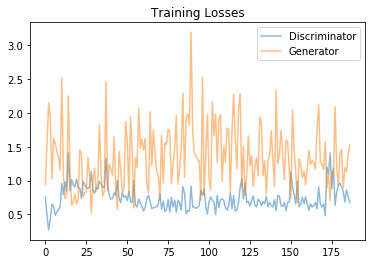

In [120]:
import matplotlib.pylab as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

#### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8308... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 0.5957... Generator Loss: 1.4292
Epoch 1/1... Discriminator Loss: 0.3174... Generator Loss: 2.2116
Epoch 1/1... Discriminator Loss: 0.3770... Generator Loss: 1.9942
Epoch 1/1... Discriminator Loss: 0.6951... Generator Loss: 1.8276
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 1.8529
Epoch 1/1... Discriminator Loss: 1.6443... Generator Loss: 0.3410
Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 0.9588... Generator Loss: 1.1155
Epoch 1/1... Discriminator Loss: 0.9636... Generator Loss: 0.8537


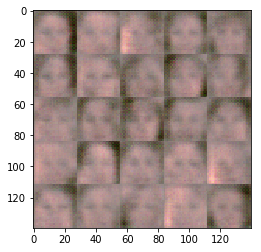

Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 2.5516
Epoch 1/1... Discriminator Loss: 0.8112... Generator Loss: 1.2492
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 1.0586
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 2.1269
Epoch 1/1... Discriminator Loss: 0.8754... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.1810... Generator Loss: 1.9105
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.3899
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 0.8102
Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.3646
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 1.6795


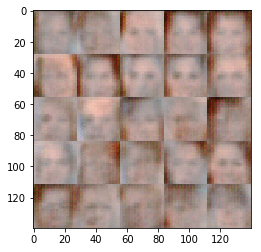

Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 1.0068
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.1134... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.5673
Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 2.0169
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 1.9282
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 1.2689


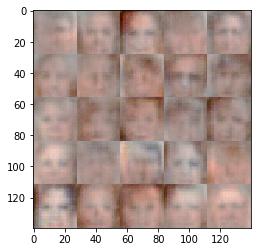

Epoch 1/1... Discriminator Loss: 1.6618... Generator Loss: 1.1830
Epoch 1/1... Discriminator Loss: 0.9236... Generator Loss: 1.1291
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 1.2640
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 1.4645
Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 1.2809
Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 1.0238
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.5148
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.5358


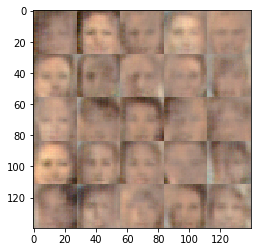

Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 1.0100
Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 1.1410
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.7837... Generator Loss: 0.3182
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 1.0540
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.4694
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.7299


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0008
beta1 = 0.6 # for the Adam Optimizer

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

In [ ]:
import matplotlib.pylab as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.